## 0.0 Planejamento da solução 

**Input - Entrada** 

1. Problema de Negócio
    -- Selecionar os clientes mais valiosos para integrar um programa de fidelização
    

2. Conjunto de dados
    -- Vendas de um e-ccomerce online durante um período de 1 ano.   
    


**Output - Saída**

A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".

Relatório com as respostas para as seguintes perguntas:
    Quem são as pessoas elegíveis para participar do programa de Insiders ?
    
    1. Quantos clientes farão parte do grupo?
    
    2. Quais as principais características desses clientes ?
    
    3. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    
    4. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    
    5. Quais as condições para uma pessoa ser elegível ao Insiders ?
    
    6. Quais as condições para uma pessoa ser removida do Insiders ?
    
    7. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    
    8. Quais ações o time de marketing pode realizar para aumentar o faturamento?

 **Tasks - Processo**

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    --O que é ser elegível. Para a empresa o que são clientes com maior valor?

        Faturamento:
            Alto Ticket MédioAlto LTVBaixa Recência ou Alta Frequência ( tempo entre as compras )

            Alto Basket Size ( quantidade média de produtos comprados )

            Baixa probabilidade de Churn
            
            Previsão alta de LTV
            
            Alta propensão de compra

        Custo:

            Baixo número de devoluções

        Experiência de compra:  

            Média alta de avaliações
            
2. Quantos clientes farão parte de cada grupo
     --Número total de clientes
         %do grupo de insiders
     
3. Quais as principais características desses clientes?
      -- Escrever caracteristicas desses clientes
              idade
              Localização
       
      -- Escrever caracteristicas do consumo
              Atributos de clusterização
              
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
        --Faturamento total do ano
        --Faturamento do grupo de insiders        
        

5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
        --LTV do grupo de insiders
        --Analise de cohort
   
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
        -- Definir a periodicidade
        -- Pessoas com caracteristicas parecidas com os outros insders do grupo


7. Quais as condições para uma pessoa ser removida do Insiders ?
         -- Definir a periodicidade
         -- Não estar dentro das características acima

8. ual a garantia que o programa Insiders é melhor que o restante da base ?
        -- teste A/B
        --teste A/B baysiano
        -- Teste de hipoteses
        
        
9. Quais ações o time de marketing pode realizar para aumentar o faturamento? 
        -- Desconto
        -- frete
        -- Visita a empresa
        -- brinde
    
        



## 0.0 Imports

In [72]:
import re
import pandas as pd

import numpy as np
import seaborn as sns

import umap.umap_ as umap
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import metrics       as m
from sklearn import preprocessing as pp
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from IPython.display import HTML


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2 Load Dataset

In [7]:
df_raw = pd.read_csv('data/ecommerce.csv',encoding='cp1252')
df_raw.drop('Unnamed: 8', axis=1, inplace=True)

In [8]:
df_raw.shape

(541909, 8)

# 1.0 Data Descriptions

In [9]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [10]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
cols_new =['Invoice_No', 'Stock_Code', 'Description', 'Quantity', 'Invoice_Date',
       'Unit_Price', 'Customer_ID', 'Country']


cols_new = list( (map(lambda x: x.lower(), cols_new)) )


df1.columns = cols_new

## 1.2 Data Dimensions

In [12]:
print(f'Numbers of rows: { df1.shape[0] }\n')
print(f'Numbers of columns: { df1.shape[1] }')

Numbers of rows: 541909

Numbers of columns: 8


## 1.3 Data Types

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fillout NA

In [15]:
# A estratégia é preencher os nAs pra fazer um estudo geral
df_missing =df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]


In [16]:
# Create reference

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange( 19000, 19000+len(df_backup), 1)

#Merge original with refrece dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#Drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [17]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [18]:
# invoicedate
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

#customerid
df1['customer_id'] = df1['customer_id'].astype('int64')


In [19]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [20]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [71]:
#central tendency - mean, median, 
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()) ).T

#Merge
e = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
e.columns = ['attributes', 'min', 'max', 'range','mean', 'median', 'std','skew','kurtosis']
e

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.1.1 Numerical Attributes

### 1.7.1 Categorical Attributes

### Invoice_no

In [22]:
# problema: O invoice tem numeros e letras

df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

#Verificar se todos os invoices são negativos
print(f'total de invoices com letras: {len(df_letter_invoices)}')

#Verificar se todos os invoices são negativos
print(f'total de invoices com valores negativos: {len(df_letter_invoices[ df_letter_invoices["quantity"] < 0 ])}')


total de invoices com letras: 9291
total de invoices com valores negativos: 9288


Todos os invoices constituidos por numeros e letras são negativos, então vou assumir que é um retorno.

## Stoke_code

In [23]:
#at_least_one_string = len(cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool( re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())

cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x:  bool( re.search( '^[a-zA-z]+$', x))),'stock_code'].unique()

#Ação
# Remover 'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### Description

In [24]:
#Ação
#Deletar description

### Country

In [25]:
len(df1['country'].unique())

38

In [26]:
#Representatividade de cada país nas compras

df1['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [27]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


#  2.0 Filtering Variable

In [48]:
df2 =df1.copy()

In [49]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [50]:
#=====================Numerical Attributes=================================
#Quantity
df2 = df2.loc[df2['unit_price']>= 0.04]


#=====================Caterical Attributes=================================
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

#Description
df2 = df2.drop(columns='description', axis=1)

#map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#Quantity
df2_returns = df2.loc[df1['quantity']<0, :]
df2_purchase = df2.loc[df1['quantity']> 0, :]



# 3.0 Feature Engeneering

In [32]:
df3= df2.copy()

In [33]:
# Data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [34]:
#Gross Revenue (Faturamento) - Quantidade * preco
df2_purchase[ 'gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']

#Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


C:\Users\PC\AppData\Local\Temp\ipykernel_8560\2607410956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase[ 'gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']


### 3.1.2 Recency - Day from last purchase

In [35]:
#Recency -> Last day purchase
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days

df_recency = df_recency[['customer_id', 'recency_days']].copy()

#Merge
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity purchase

In [36]:
#Products number
df_freq = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref =pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
invoice_no       91
dtype: int64

### 3.1.3 Quantity of products purchase

In [37]:
#Products number
df_freq = df2_purchase[['customer_id', 'quantity']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref =pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
invoice_no       91
quantity         91
dtype: int64

### 3.1.4 Avg Ticket

In [38]:
#AVG tiket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
invoice_no       91
quantity         91
avg_ticket       91
dtype: int64

### 3.1.5 Avg Recency Days

In [39]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], 
                                                                            ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
quantity              91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency Purchase

In [40]:
#Calcular a data máx, a data min, calcular a diferença uma da outra 
df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
df2_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()
df2_purchase.head()

,invoice_date
customer_id,
12346,1
12347,7
12348,4
12349,1
12350,1


In [41]:
#COmo Fazer todo esse processo apenas uma vez
df_aux = (df2[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg(max_ =('invoice_date', 'max'),
                                                                min_ =('invoice_date', 'min'),
                                                                days_ =('invoice_date', lambda x:(( x.max() - x.min()).days)+1),
                                                                buy_ =('invoice_date', 'count'))).reset_index()
#Frequency
df_aux['frequency'] =df_aux[['buy_', 'days_']].apply( lambda x: x['buy_']/ x['days_'] if x['days_'] != 0 else 0, axis=1)

#Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

In [42]:
df_aux.sample(10)

,customer_id,max_,min_,days_,buy_,frequency
5391,21484,2017-08-09,2017-08-09,1,1,1.000000
5437,21577,2017-08-28,2017-08-28,1,1,1.000000
2504,15739,2017-10-02,2017-10-02,1,1,1.000000
4797,19894,2017-03-16,2017-03-16,1,1,1.000000
1321,14132,2017-12-05,2017-06-07,182,12,0.065934
2625,15904,2017-11-29,2017-11-29,1,1,1.000000
5746,22616,2017-11-29,2017-11-29,1,1,1.000000
4835,20000,2017-03-23,2017-03-23,1,1,1.000000
3161,16643,2017-04-06,2017-04-06,1,1,1.000000
2449,15665,2017-06-22,2017-04-08,76,2,0.026316


### 3.1.8 Number of Returns

In [51]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
quantity              91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtde_returns           0
dtype: int64

###  3.1.9. Basket Size - Quantidade de Items por Cesta ( Quantity )

In [54]:
df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
quantity              91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtde_returns           0
avg_basket_size       91
dtype: int64

###  3.2.0. Unique Basket Size - Quantidade de produtos distintos por compra

In [55]:
df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
invoice_no                  91
quantity                    91
avg_ticket                  91
avg_recency_days          2816
frequency                    0
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA - Exploratory Data Analysis 

In [56]:
df4 =df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
invoice_no                0
quantity                  0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

# 5.0 Data Preparations

In [57]:
df5 =df4.copy()

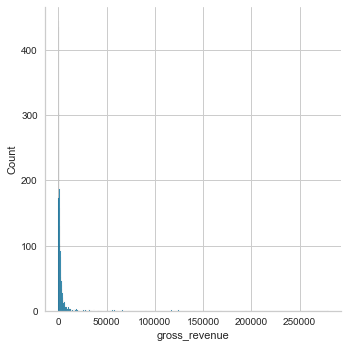

In [58]:
sns.displot(df5['gross_revenue'])


In [59]:
# Standard Scaler
ss = pp.StandardScaler()
df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform( df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']])

In [60]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.249733,3.958037,3.193307,6.0,-0.032549,-35.500000,0.486111,40.0,50.970588,0.617647
1,13047,0.045683,-0.106602,0.370056,11.0,-0.031824,-27.250000,0.048780,35.0,154.444444,11.666667
2,12583,0.373960,-0.801192,1.047636,24.0,-0.022180,-23.187500,0.045699,50.0,335.200000,7.600000
3,13748,-0.170252,0.395046,-0.081664,8.0,-0.017392,-92.666667,0.017921,0.0,87.800000,4.800000
4,15100,-0.177082,3.456388,-0.307524,2.0,0.231589,-8.600000,0.136364,22.0,26.666667,0.333333


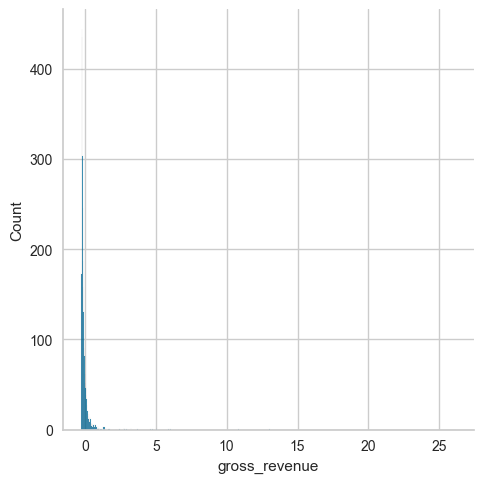

In [61]:
sns.displot(df5['gross_revenue'])

# 6.0 Feature Selections

In [62]:
df6 =df5.copy()

# 7.0 Hyper Parameter Fine-Tuning

In [63]:
X =df6.drop(columns=['customer_id'])

In [64]:
clusters = [2, 3, 4, 5, 6, 7]

## <font color=blue> 7.1 Within-Cluster Sum of Square (WSS) </font>

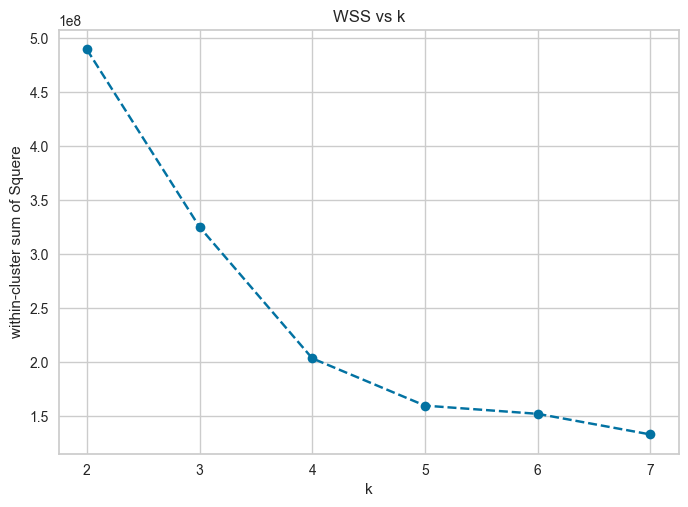

In [65]:
wss = []

for k in clusters:
    #model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    #model training
    kmeans.fit( X)
    #validation
    wss.append(kmeans.inertia_)

    #Plot wss Elbow Method
plt.plot( clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('k')
plt.ylabel('within-cluster sum of Squere')
plt.title('WSS vs k');


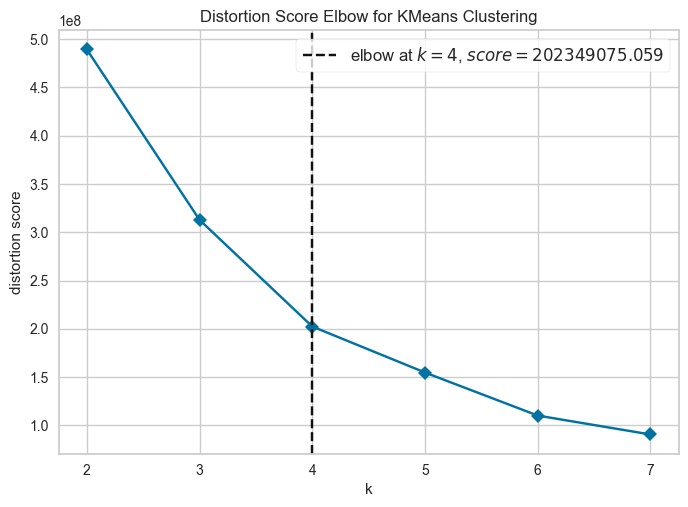

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

## <font color=blue> 7.1 Silhoutete Sccore (SS) </font>

In [ ]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters,metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

### 7.1.1 Silhouette Analysis

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(25,18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

#  8.0 Model Training

## 8.1 K-Means

In [73]:
#Model definition
k=3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

#Model training
kmeans.fit( X )

#Clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [74]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [75]:
# WSS ( within-cluster sum of square)
print(f'WSS value: {kmeans.inertia_}')

# SS (Silhouette Score)
print(f'SS value: {m.silhouette_score ( X , labels , metric = "euclidean")}')

WSS value: 324920941.1034983
SS value: 0.8987946953829512


#  9.0 Cluster Analysis

In [76]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,0.249733,3.958037,3.193307,6.0,-0.032549,-35.500000,0.486111,40.0,50.970588,0.617647,1
1,13047,0.045683,-0.106602,0.370056,11.0,-0.031824,-27.250000,0.048780,35.0,154.444444,11.666667,1
2,12583,0.373960,-0.801192,1.047636,24.0,-0.022180,-23.187500,0.045699,50.0,335.200000,7.600000,1
3,13748,-0.170252,0.395046,-0.081664,8.0,-0.017392,-92.666667,0.017921,0.0,87.800000,4.800000,1
4,15100,-0.177082,3.456388,-0.307524,2.0,0.231589,-8.600000,0.136364,22.0,26.666667,0.333333,1


## 9.1 Visualization Inspection

C:\Users\PC\anaconda3\envs\pa005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


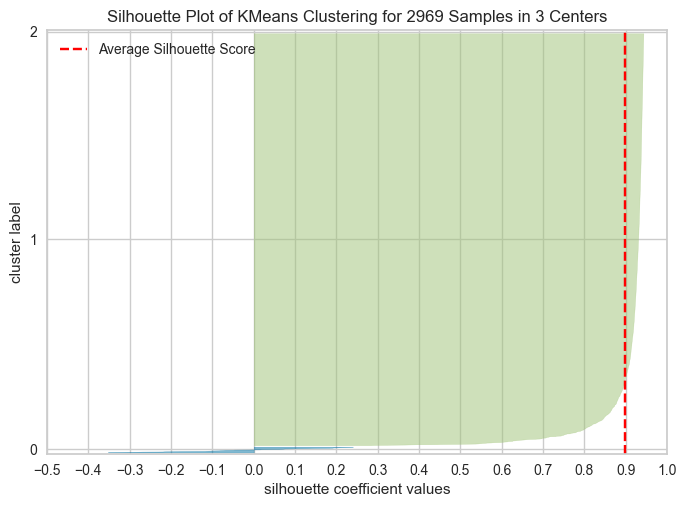

In [78]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d Plot

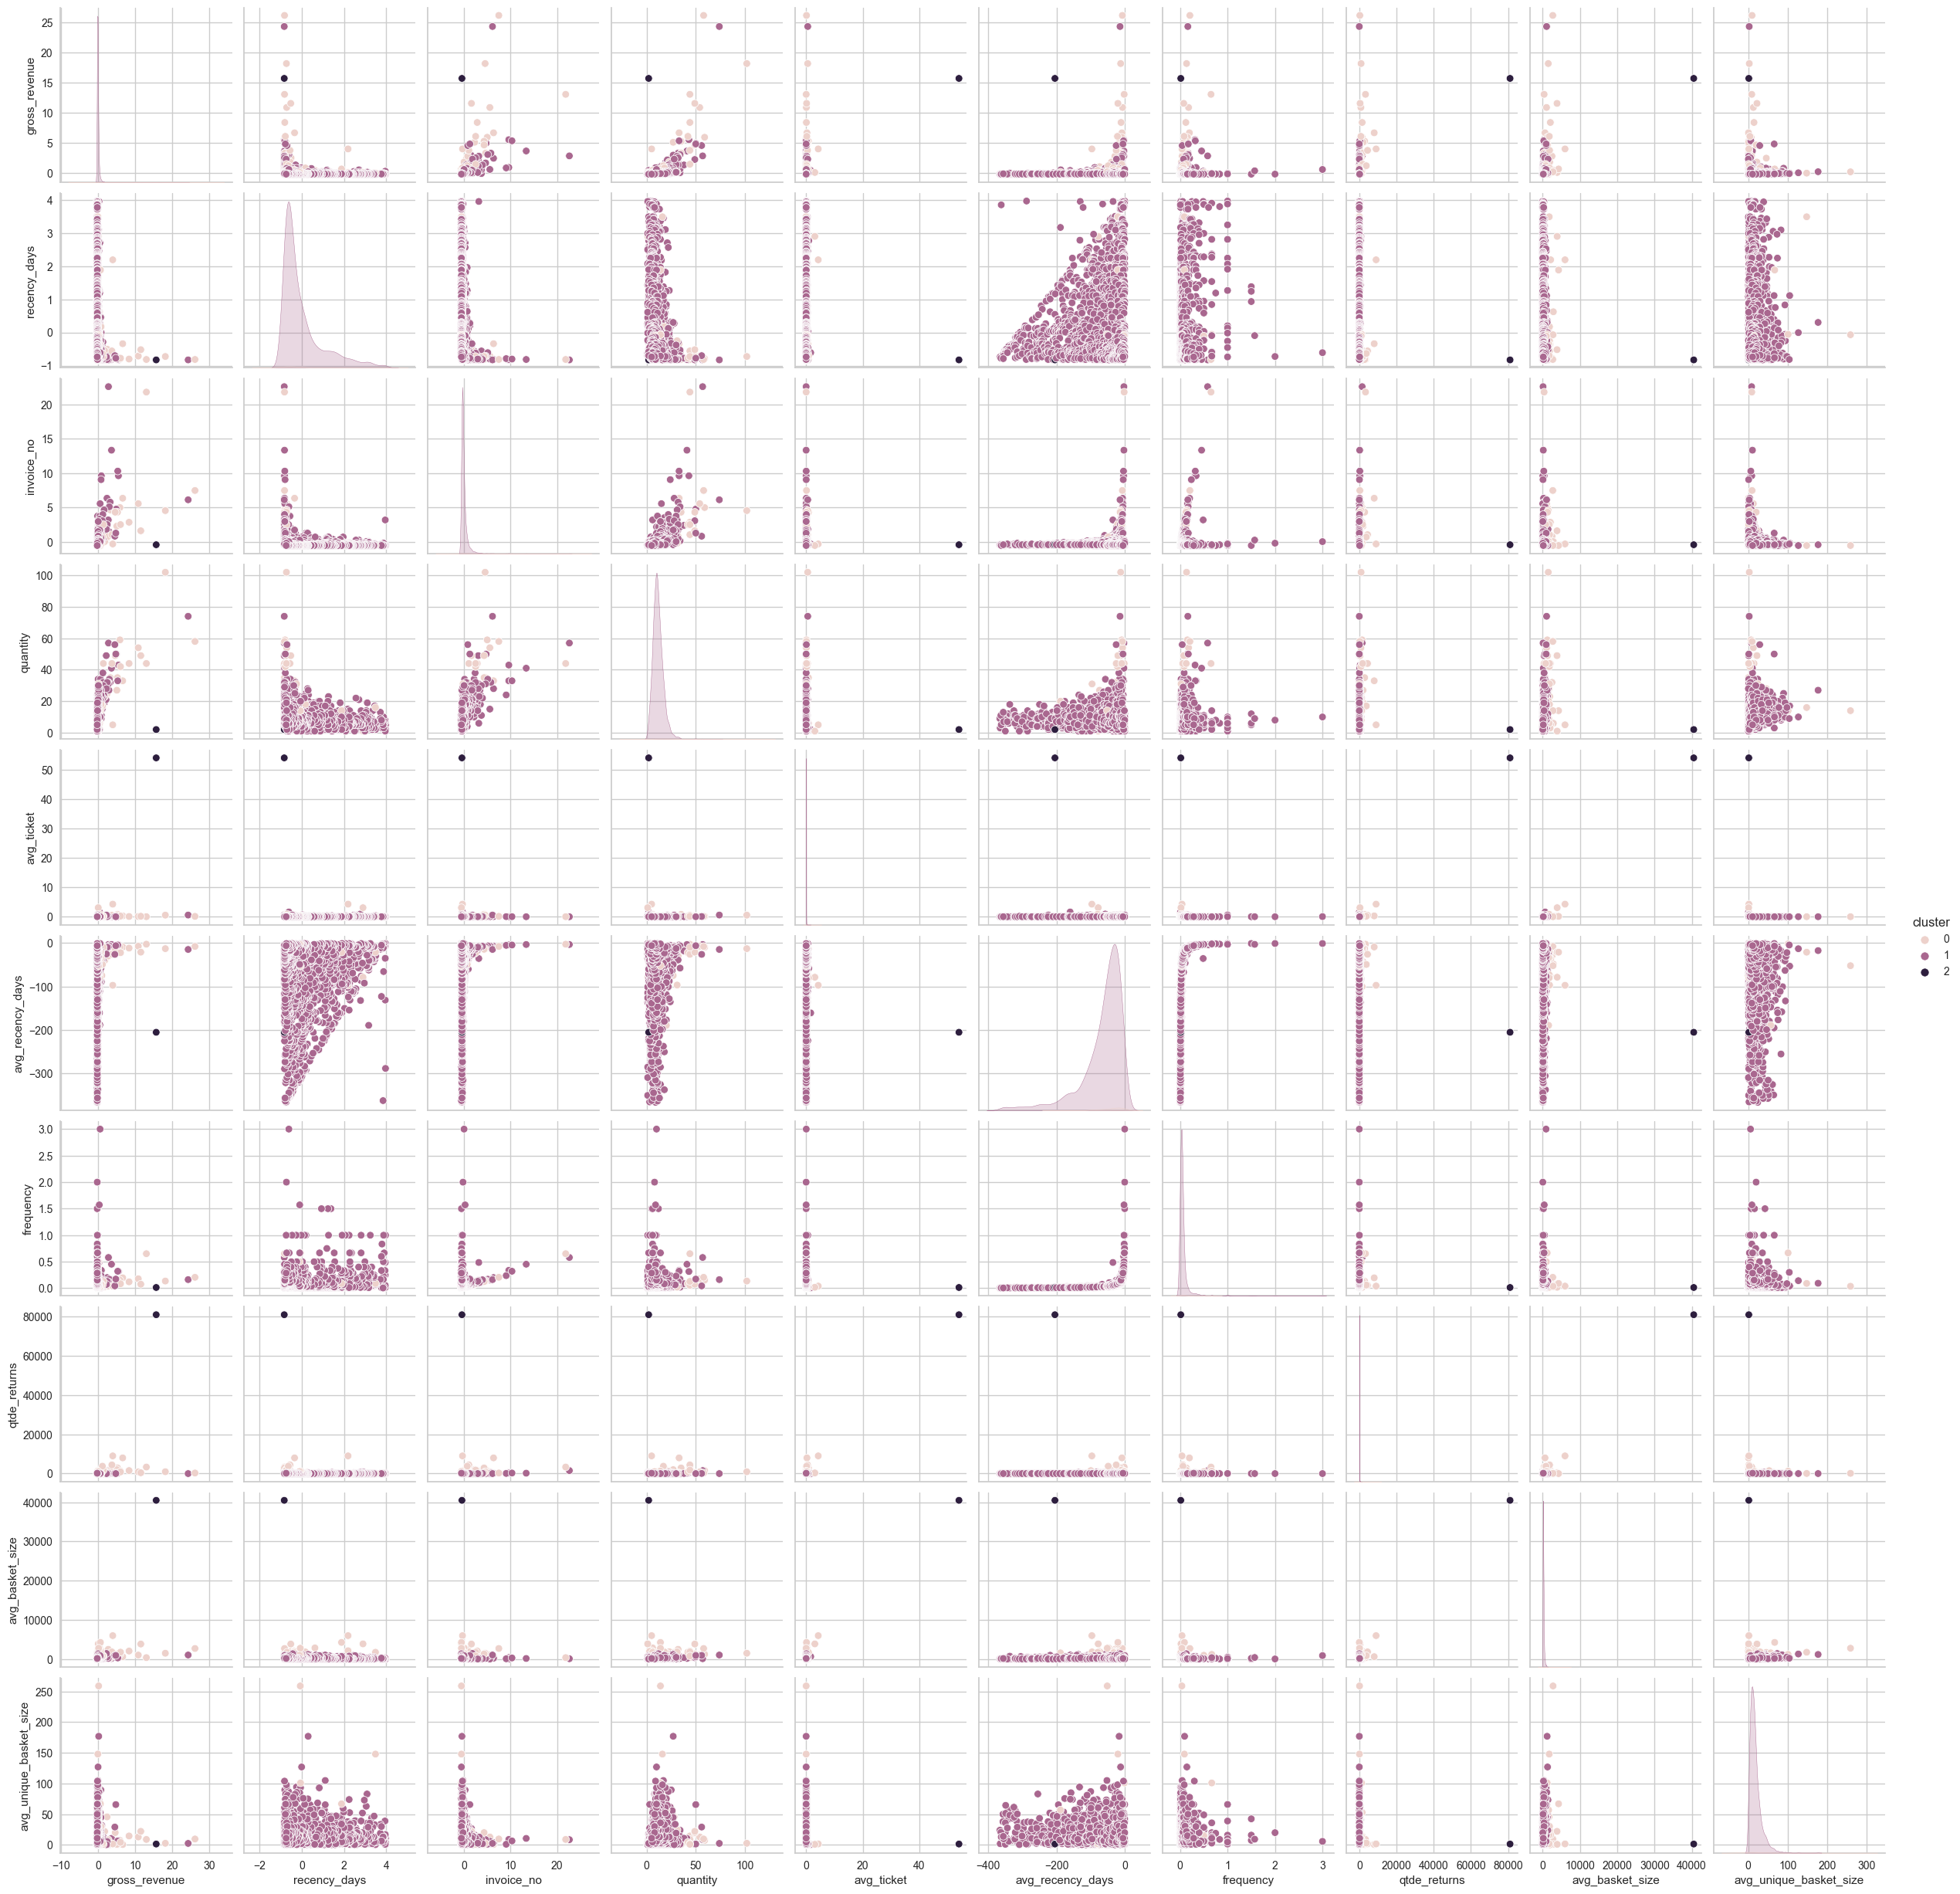

In [79]:
df_viz = df9.drop('customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.2.3 UMAP

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\PC\anaconda3\envs\pa005\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

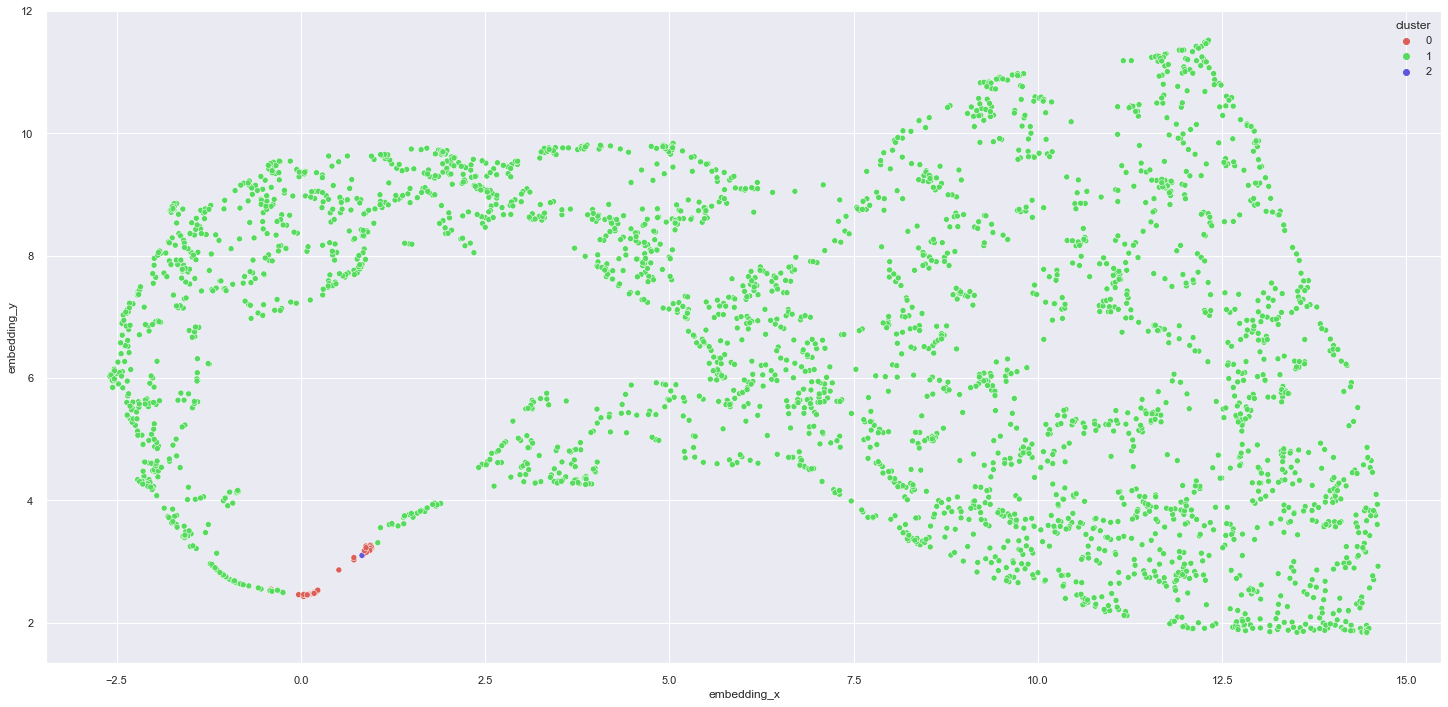

In [80]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(X)

#embeding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot MAP
jupyter_settings()
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', 
                hue='cluster',
                palette=sns.color_palette('hls', n_colors= len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.2 Cluster Profile

In [81]:
# cluster number
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id']/ df_cluster['customer_id'].sum()*100)

#AVG gross revenue

df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()

df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#AVG recency_days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

#AVG invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

#Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster =pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,41,1.380936,3.633128,-0.124484,1.838147,0.308438
1,1,2927,98.585382,-0.056243,0.002026,-0.025604,-0.022809
2,2,1,0.033681,15.665532,-0.826918,-0.420454,54.116300


# <font color='red' > 10. Deploy</font>